In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split


In [59]:
data_dir = '../data'
merged_df = pd.read_csv(os.path.join(data_dir, '../data/merged_df.csv'))
merged_df.head()

,lat_bounds,lon_bounds,year,month,fraction_of_burnable_area,burned_area,CL,lccs_class,pr,tas,tasmax
0,52.0,-10.00,2010,7,0.805087,0.0,1,130,131.5,15.700000,18.800001
1,52.0,-10.00,2010,5,0.805087,0.0,1,130,58.9,11.000000,15.000000
2,52.0,-10.00,2010,8,0.805087,0.0,1,130,35.8,14.700000,18.400000
3,52.0,-10.00,2010,6,0.805087,0.0,1,130,49.0,14.900001,19.100000
4,52.0,-9.75,2010,7,0.937479,0.0,0,210,168.1,14.600000,17.400000


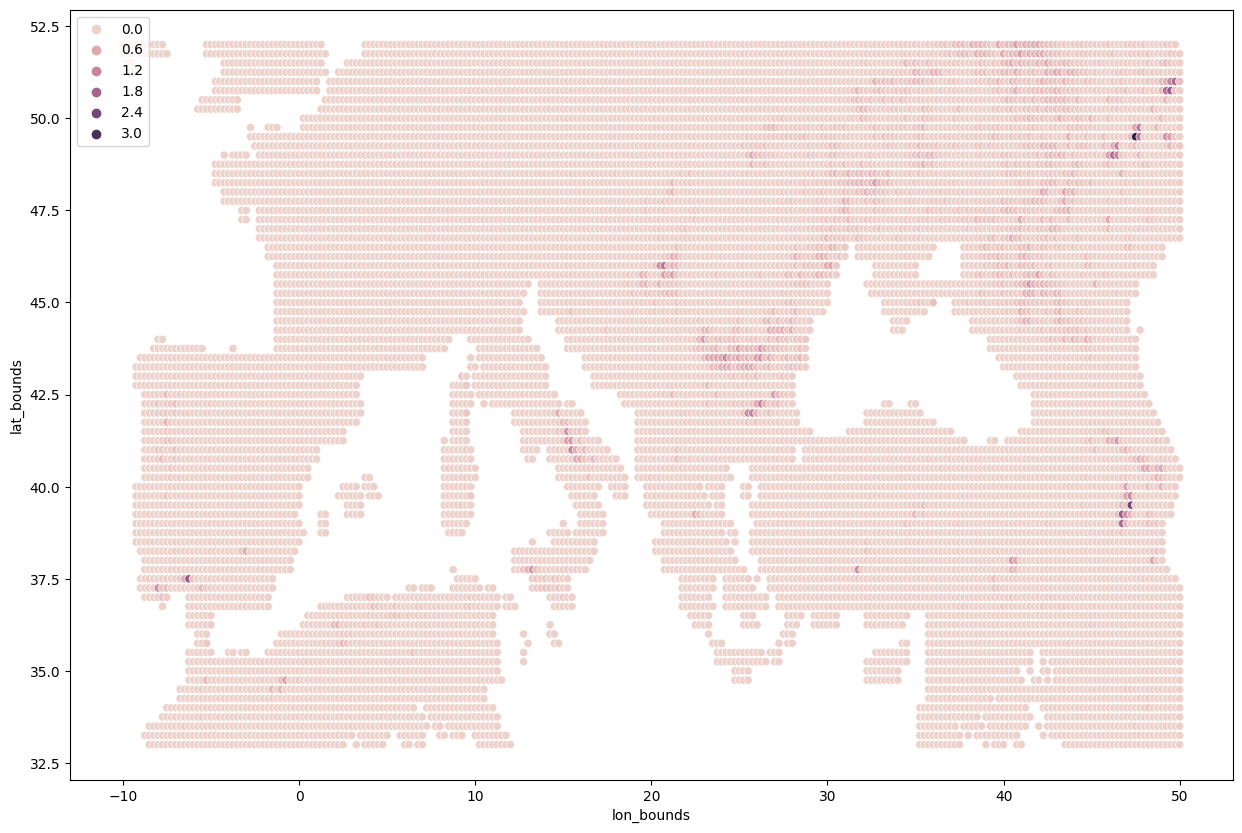

In [60]:
month = 8
year = 2004
merged_df_plotting = merged_df[(merged_df['month'] == month) & (merged_df['year'] == year)]

plt.figure(figsize=(15,10))
sns.scatterplot(data=merged_df_plotting, x='lon_bounds', y='lat_bounds', hue = 'burned_area')
plt.legend(loc='upper left');

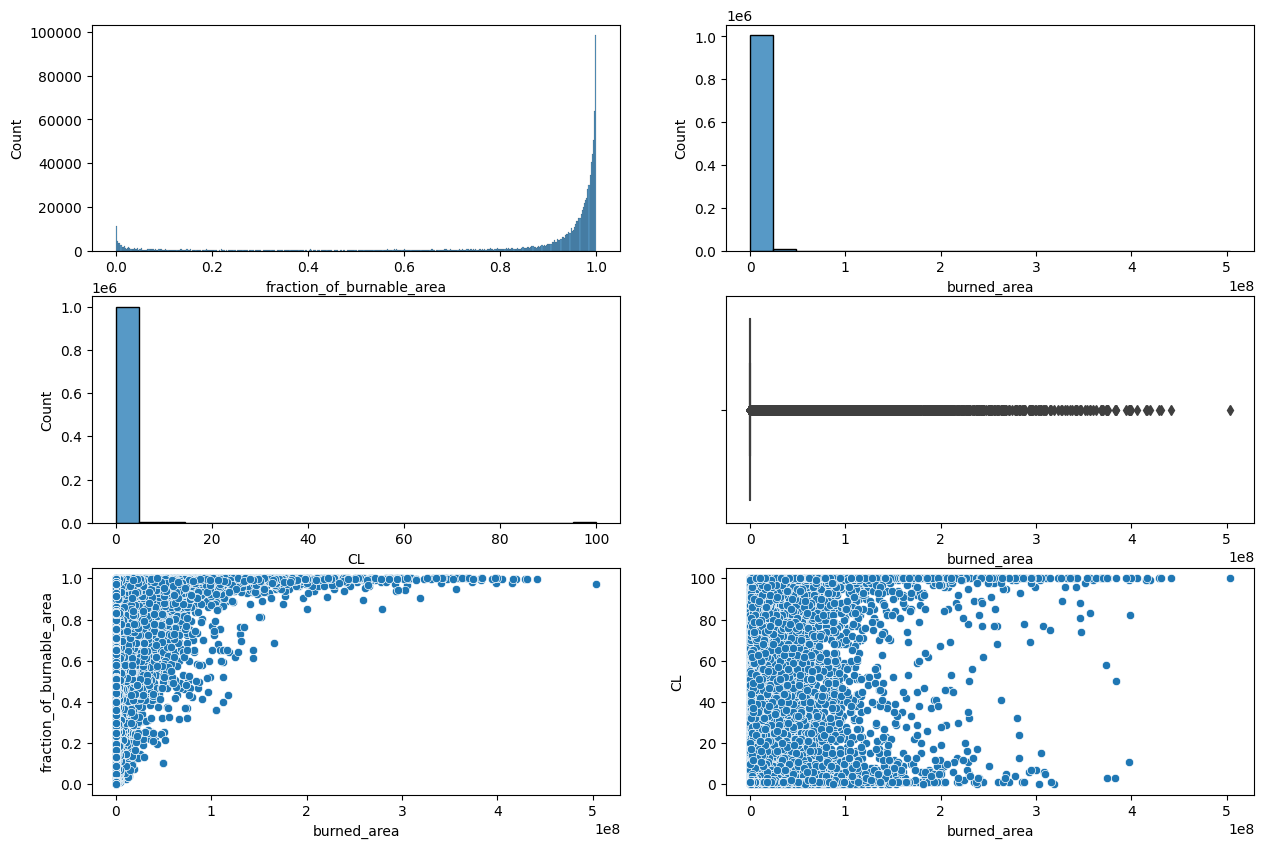

In [61]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 10))

sns.histplot(merged_df['fraction_of_burnable_area'], ax=ax1)
sns.histplot(merged_df['burned_area'], ax=ax2)
sns.histplot(merged_df['CL'], ax=ax3)
sns.boxplot(data = merged_df, x= 'burned_area', ax=ax4)
sns.scatterplot(data=merged_df, x='burned_area', y='fraction_of_burnable_area', ax=ax5)
sns.scatterplot(data=merged_df, x='burned_area', y='CL', ax=ax6)

plt.show();


 # filtering dataset

1. seems there is one outlier in burned area 
2. the distribution for 'fraction_of_burnable_area' is skewd and data wit less than 80% could be removed

In [62]:
merged_df_filtered = merged_df[merged_df['fraction_of_burnable_area'] > 0.8]
#mask = (merged_df_filtered['CL'] > 50) # keeps only pixels where confidance that burning is real is abou 50%
#merged_df_filtered = merged_df_filtered[mask].reset_index(drop=True)

merged_df_filtered = merged_df_filtered[merged_df_filtered['CL'] > 50]
merged_df_filtered.shape

(8051, 11)

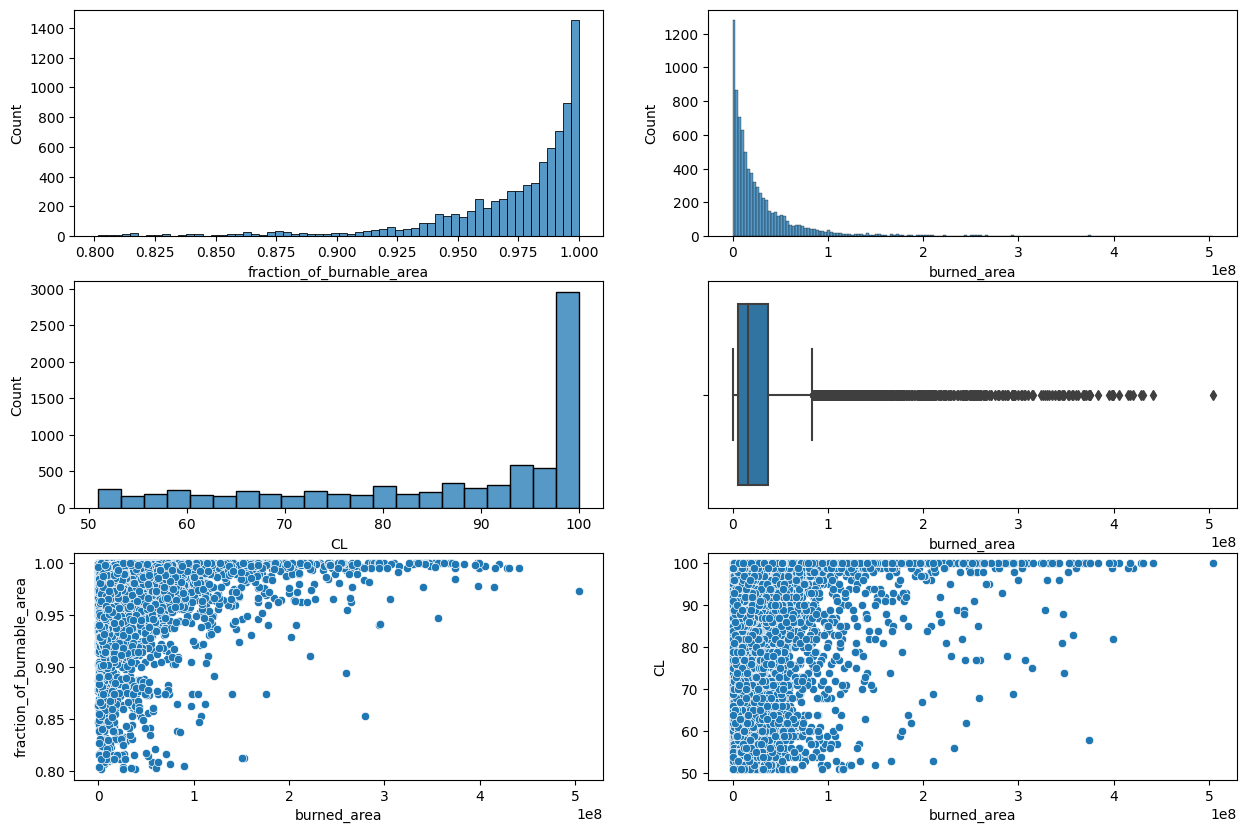

In [63]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 10))

sns.histplot(merged_df_filtered['fraction_of_burnable_area'], ax=ax1)
sns.histplot(merged_df_filtered['burned_area'], ax=ax2)
sns.histplot(merged_df_filtered['CL'], ax=ax3)
sns.boxplot(data = merged_df_filtered, x= 'burned_area', ax=ax4)
sns.scatterplot(data=merged_df_filtered, x='burned_area', y='fraction_of_burnable_area', ax=ax5)
sns.scatterplot(data=merged_df_filtered, x='burned_area', y='CL', ax=ax6)

plt.show();

I would not remove more of the burned area 'outliers' since the outliers are what we are actually looking for

# Splitting the data

In [64]:
y = merged_df_filtered['burned_area']
X = merged_df_filtered.drop('burned_area', axis=1)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [66]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)

X_train:  (5635, 10)
y_train:  (5635,)


# Normalisation

## longitude and latitude

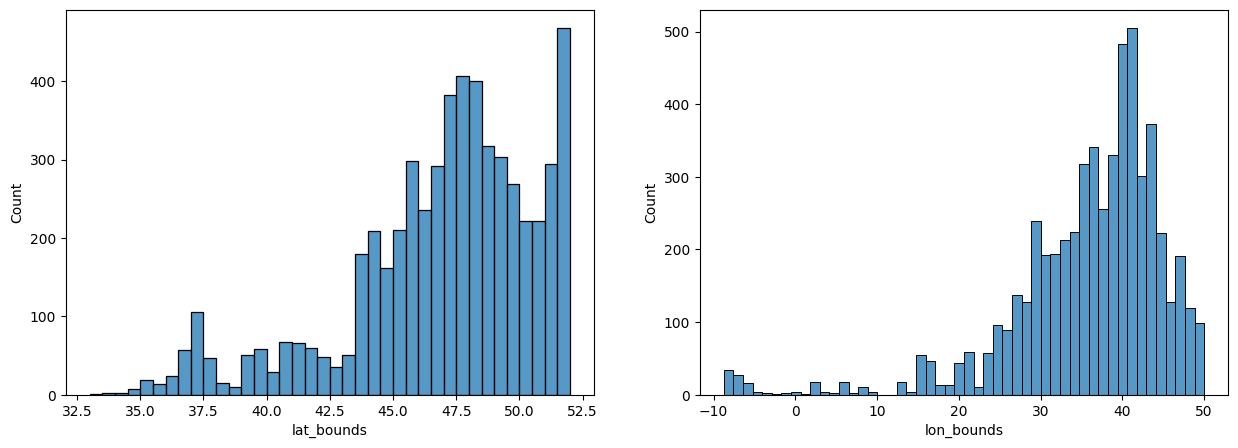

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(X_train['lat_bounds'], ax= ax1)
sns.histplot(X_train['lon_bounds'], ax= ax2);

the lon and lat columns need normalising but I am not sure what is the best approach.<br />
ChatGPT recommended to map longitude and latitude to x and y coordinates -> represents the data in a two-dimensional space

x = cos(lat) * cos(lon) <br />
y = cos(lat) * sin(lon)

In [68]:
X_train['x'] = np.cos(X_train['lat_bounds']) * np.cos(X_train['lon_bounds'])
X_train['y'] = np.cos(X_train['lat_bounds']) * np.sin(X_train['lon_bounds'])
X_train = X_train.drop(['lat_bounds', 'lon_bounds'], axis =1).reset_index(drop = True)

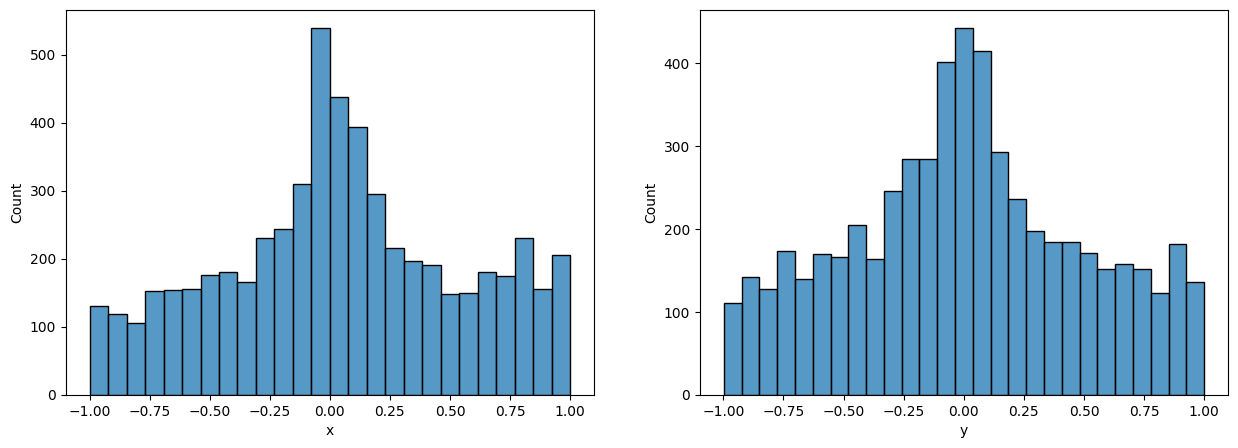

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(X_train['x'], ax= ax1)
sns.histplot(X_train['y'], ax= ax2);

this seems better, both coordinates have normal distribution

In [70]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)

X_train:  (5635, 10)
y_train:  (5635,)


## time columns

In [71]:
# we have only one month atm so I am dropping it for now
X_train = X_train.drop('month', axis=1)

In [72]:
# for now I am treating year as ordinal value. We will need to discuss how to treat it properly later
o_encoder = OrdinalEncoder(categories = [[2001, 2002, 2003, 2004, 2005,
                                         2006, 2007, 2008, 2009, 2010,
                                         2011, 2012, 2013, 2014, 2015, 
                                         2016, 2017, 2018, 2019]])

o_encoder.fit(X_train[['year']])
X_train['year'] = o_encoder.transform(X_train[['year']])

X_train.head()

,year,fraction_of_burnable_area,CL,lccs_class,pr,tas,tasmax,x,y
0,11.0,0.977176,99,100,48.4,19.600000,26.800001,0.049229,-0.019819
1,13.0,0.968473,100,10,38.3,21.200000,27.300001,0.174049,0.721457
2,5.0,0.993253,100,10,59.9,20.800001,26.300001,0.065194,0.149385
3,0.0,0.991962,99,10,25.7,22.600000,29.000000,0.399408,-0.598468
4,3.0,0.975668,79,11,62.5,19.800001,26.300001,-0.503417,-0.634964


# climate data

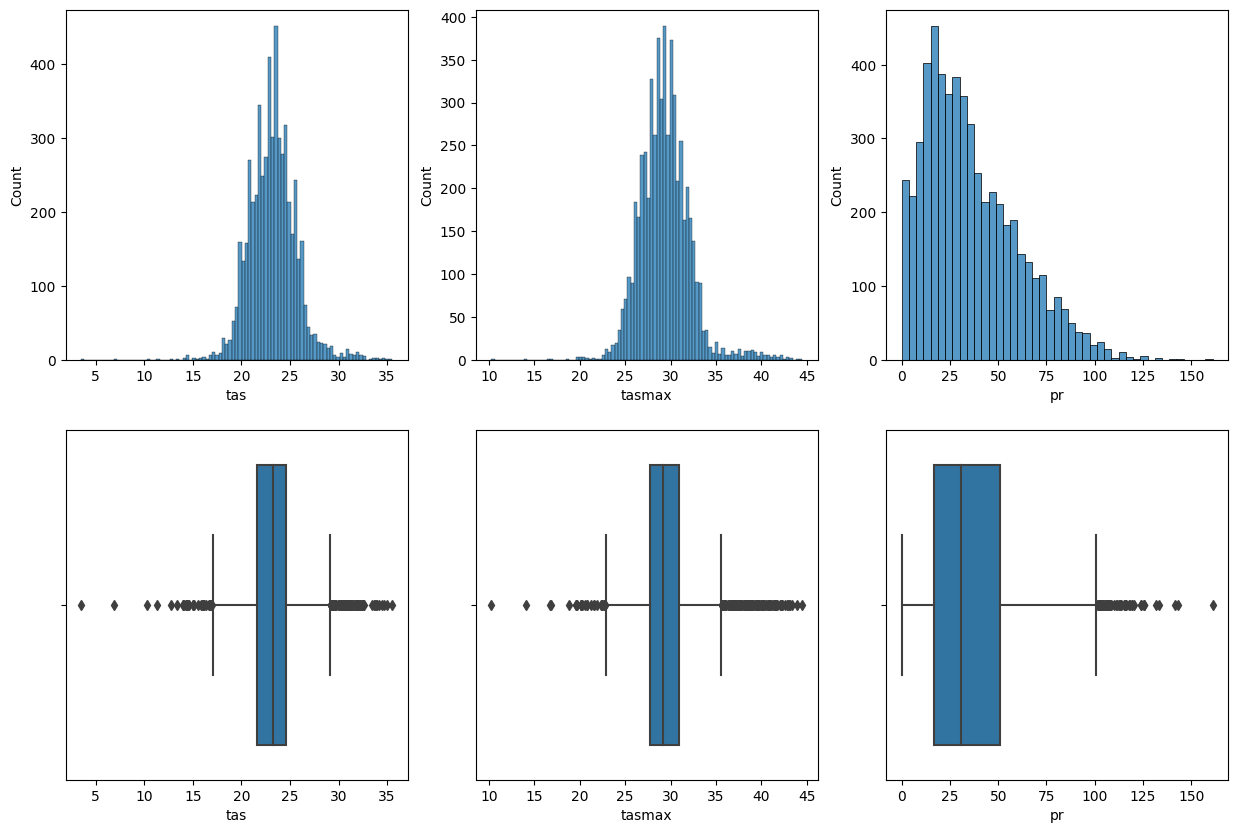

In [73]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
sns.histplot(X_train['tas'], ax= ax1)
sns.histplot(X_train['tasmax'], ax= ax2)
sns.histplot(X_train['pr'], ax= ax3)


sns.boxplot(data = X_train, x= 'tas', ax=ax4)
sns.boxplot(data = X_train, x= 'tasmax', ax=ax5)
sns.boxplot(data = X_train, x= 'pr', ax=ax6);

tas and maxtas seem to have normal distribution but there are some outliers so I am using RobustScaler on all three

In [74]:
rb_scaler = RobustScaler()
X_train[['tas', 'tasmax', 'pr']] = rb_scaler.fit_transform(X_train[['tas', 'tasmax', 'pr']])

X_train.head()

,year,fraction_of_burnable_area,CL,lccs_class,pr,tas,tasmax,x,y
0,11.0,0.977176,99,100,0.524444,-1.200000,-0.75000,0.049229,-0.019819
1,13.0,0.968473,100,10,0.225185,-0.666667,-0.59375,0.174049,0.721457
2,5.0,0.993253,100,10,0.865185,-0.800000,-0.90625,0.065194,0.149385
3,0.0,0.991962,99,10,-0.148148,-0.200000,-0.06250,0.399408,-0.598468
4,3.0,0.975668,79,11,0.942222,-1.133333,-0.90625,-0.503417,-0.634964


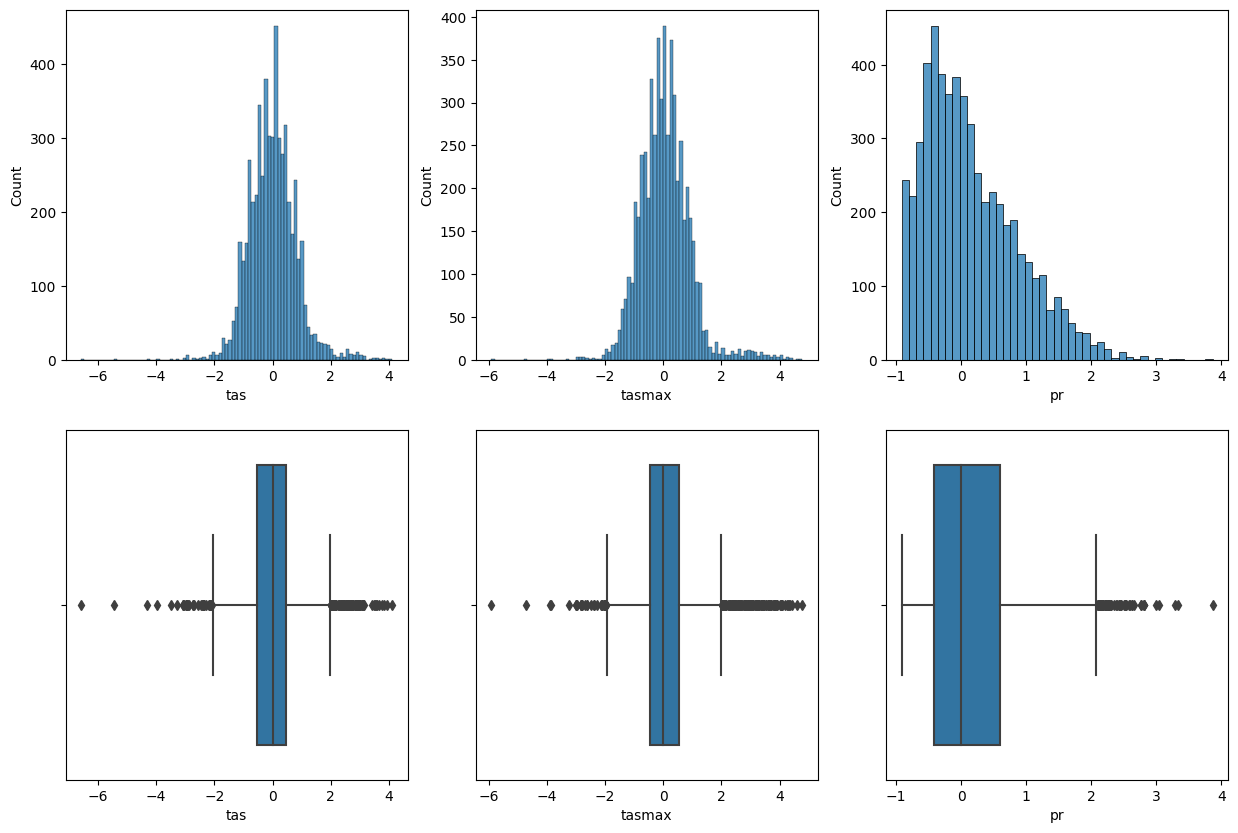

In [75]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
sns.histplot(X_train['tas'], ax= ax1)
sns.histplot(X_train['tasmax'], ax= ax2)
sns.histplot(X_train['pr'], ax= ax3)


sns.boxplot(data = X_train, x= 'tas', ax=ax4)
sns.boxplot(data = X_train, x= 'tasmax', ax=ax5)
sns.boxplot(data = X_train, x= 'pr', ax=ax6);

data is rescaled

# fire data

### fraction_of_burnable_area
this is already in a range of 0 - 1

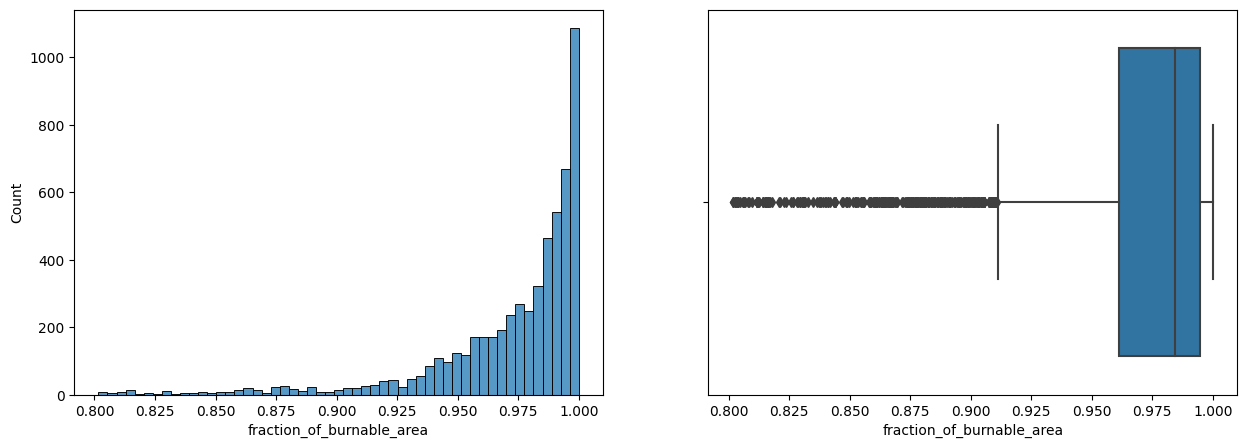

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(X_train['fraction_of_burnable_area'], ax= ax1)
sns.boxplot(data = X_train, x= 'fraction_of_burnable_area', ax=ax2);

the distribution is not normal and there are outliers. I will perform Robust Scaer as well but not sure whether this is neccessary

In [77]:
rb_scaler2 = RobustScaler()
X_train[['fraction_of_burnable_area']] = rb_scaler.fit_transform(X_train[['fraction_of_burnable_area']])

X_train.head()

,year,fraction_of_burnable_area,CL,lccs_class,pr,tas,tasmax,x,y
0,11.0,-0.211335,99,100,0.524444,-1.200000,-0.75000,0.049229,-0.019819
1,13.0,-0.471325,100,10,0.225185,-0.666667,-0.59375,0.174049,0.721457
2,5.0,0.268987,100,10,0.865185,-0.800000,-0.90625,0.065194,0.149385
3,0.0,0.230426,99,10,-0.148148,-0.200000,-0.06250,0.399408,-0.598468
4,3.0,-0.256387,79,11,0.942222,-1.133333,-0.90625,-0.503417,-0.634964


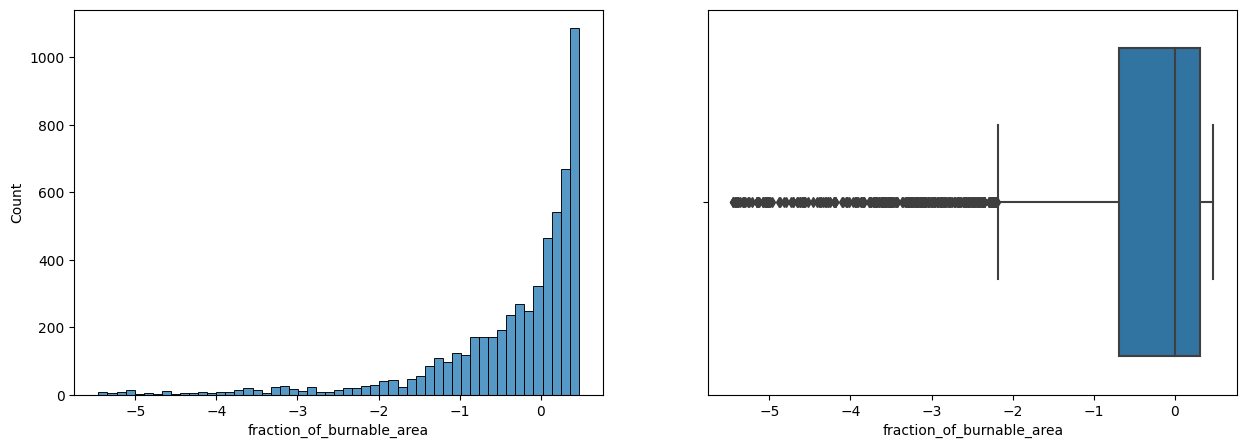

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(X_train['fraction_of_burnable_area'], ax= ax1)
sns.boxplot(data = X_train, x= 'fraction_of_burnable_area', ax=ax2);

### confidance of pixel actually burning

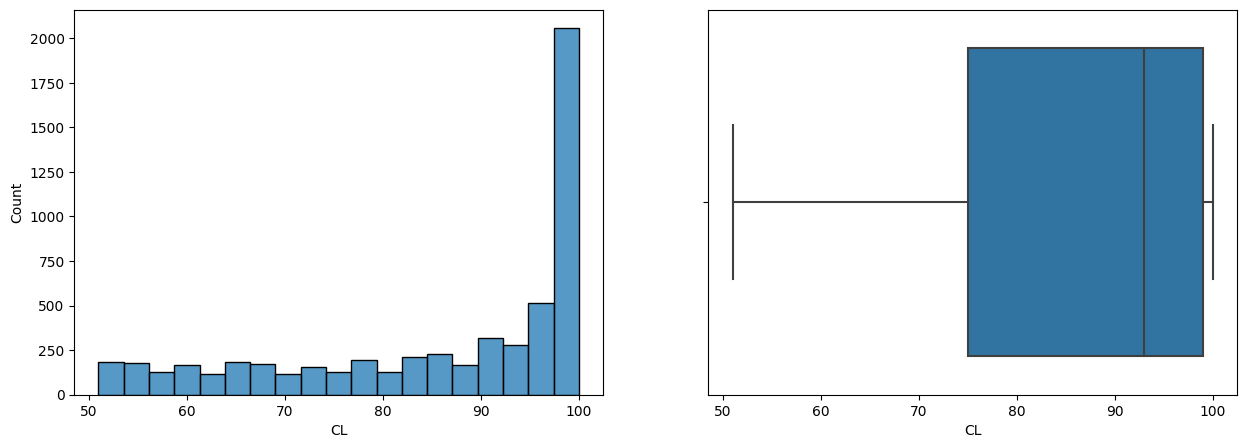

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(X_train['CL'], ax= ax1)
sns.boxplot(data = X_train, x= 'CL', ax=ax2);

no outliers but also not a normal distribution so I am using MinMaxScaler

In [80]:
mm_scaler = MinMaxScaler()

X_train[['CL']] = rb_scaler.fit_transform(X_train[['CL']])
X_train.head()

,year,fraction_of_burnable_area,CL,lccs_class,pr,tas,tasmax,x,y
0,11.0,-0.211335,0.250000,100,0.524444,-1.200000,-0.75000,0.049229,-0.019819
1,13.0,-0.471325,0.291667,10,0.225185,-0.666667,-0.59375,0.174049,0.721457
2,5.0,0.268987,0.291667,10,0.865185,-0.800000,-0.90625,0.065194,0.149385
3,0.0,0.230426,0.250000,10,-0.148148,-0.200000,-0.06250,0.399408,-0.598468
4,3.0,-0.256387,-0.583333,11,0.942222,-1.133333,-0.90625,-0.503417,-0.634964


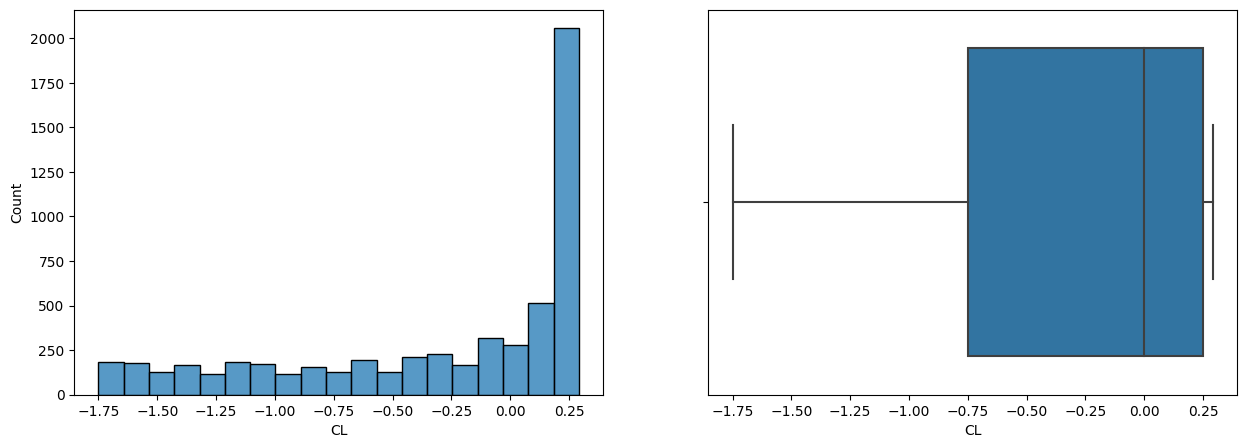

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(X_train['CL'], ax= ax1)
sns.boxplot(data = X_train, x= 'CL', ax=ax2);

### burned area

In [82]:
y_train.head()

557313    14650454.0
806663    10893927.0
321817    42448750.0
78151     26242022.0
603522     9605975.0
Name: burned_area, dtype: float64

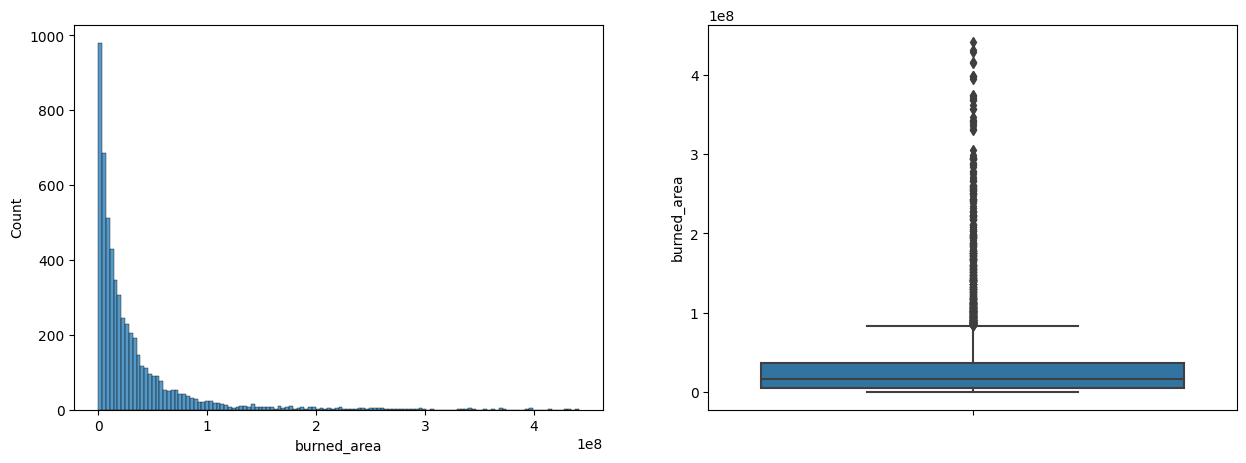

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(y_train, ax=ax1)
sns.boxplot(y=y_train, ax=ax2);

distribution is not normal and there are outliers but this is to be expected from th data and I dont know whether it should be treated

### landcover data

In [86]:
X_train.head()

,year,fraction_of_burnable_area,CL,lccs_class,pr,tas,tasmax,x,y
0,11.0,-0.211335,0.250000,100,0.524444,-1.200000,-0.75000,0.049229,-0.019819
1,13.0,-0.471325,0.291667,10,0.225185,-0.666667,-0.59375,0.174049,0.721457
2,5.0,0.268987,0.291667,10,0.865185,-0.800000,-0.90625,0.065194,0.149385
3,0.0,0.230426,0.250000,10,-0.148148,-0.200000,-0.06250,0.399408,-0.598468
4,3.0,-0.256387,-0.583333,11,0.942222,-1.133333,-0.90625,-0.503417,-0.634964


lccs_is are classes so I use OneHot Encoder

In [88]:
ohe = OneHotEncoder(sparse = False) 

ohe.fit(X_train[['lccs_class']])
X_train[ohe.get_feature_names_out()] = ohe.transform(X_train[['lccs_class']])
X_train.drop(columns = ["lccs_class"], inplace = True)

X_train.head()

,year,fraction_of_burnable_area,CL,pr,tas,tasmax,x,y,lccs_class_10,lccs_class_11,...,lccs_class_61,lccs_class_70,lccs_class_90,lccs_class_100,lccs_class_110,lccs_class_120,lccs_class_130,lccs_class_150,lccs_class_160,lccs_class_180
0,11.0,-0.211335,0.250000,0.524444,-1.200000,-0.75000,0.049229,-0.019819,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13.0,-0.471325,0.291667,0.225185,-0.666667,-0.59375,0.174049,0.721457,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,0.268987,0.291667,0.865185,-0.800000,-0.90625,0.065194,0.149385,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.230426,0.250000,-0.148148,-0.200000,-0.06250,0.399408,-0.598468,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,-0.256387,-0.583333,0.942222,-1.133333,-0.90625,-0.503417,-0.634964,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
X_train.shape

(5635, 26)

In [84]:
#def pivot_fire(fire_df):
#    
#    df_pivoted = pd.pivot_table(fire_df, 
#                                index=['lat_bounds', 'lon_bounds', 'year'],
#                                columns='month', 
#                                values=['fraction_of_burnable_area', 'burned_area', 'CL'])
#
#    new_columns = []
#    for month in range(5, 9):
#        new_columns.extend([f'{month}_fraction', f'{month}_burned', f'{month}_CL'])
#    df_pivoted.columns = new_columns
#    df_pivoted = df_pivoted.reset_index()
#
#    return df_pivoted

In [85]:
#fire_pivoted = pivot_fire(fire_df)
#fire_pivoted.head()